In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from scipy import stats as stats
from scipy.stats import rv_continuous, rv_histogram, norm, beta, multivariate_normal

import warnings
warnings.filterwarnings("ignore")


np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = '{:.3f}'.format


N = 10000       # number of random variates to generate

In [36]:
# define a new class pertm_gen: a generator for the PERT distribution

class pertm_gen(rv_continuous):
    '''modified beta_PERT distribution'''

 
    def _shape(self, min, mode, max, lmb):
        s_alpha = 1+ lmb*(mode - min)/(max-min)
        s_beta = 1 + lmb*(max - mode)/(max-min)
        return [s_alpha, s_beta]


    def _cdf(self, x, min, mode, max, lmb):
        s_alpha, s_beta = self._shape(min, mode, max, lmb)
        z = (x - min) / (max - min)
        cdf = beta.cdf(z, s_alpha, s_beta)
        return cdf

    def _ppf(self, p, min, mode, max, lmb):
        s_alpha, s_beta = self._shape(min, mode, max, lmb)
        ppf = beta.ppf(p, s_alpha, s_beta)
        ppf = ppf * (max - min) + min
        return ppf


    def _mean(self, min, mode, max, lmb):
        mean = (min + lmb * mode + max) / (2 + lmb)
        return mean

    def _var(self, min, mode, max, lmb):
        mean = self._mean(min, mode, max, lmb)
        var = (mean - min) * (max - mean) / (lmb + 3)
        return var

    def _skew(self, min, mode, max, lmb):
        mean = self._mean(min, mode, max, lmb)
        skew1 = (min + max - 2*mean) / 4
        skew2 = (mean - min) * (max  - mean)
        skew2 = np.sqrt(7 / skew2)
        skew = skew1 * skew2
        return skew

    def _kurt(self, min, mode, max, lmb):
        a1,a2 = self._shape(min, mode, max, lmb)
        kurt1 = a1 + a2 +1
        kurt2 = 2 * (a1 + a2)**2
        kurt3 = a1 * a2 * (a1 + a2 - 6)
        kurt4 = a1 * a2 * (a1 + a2 + 2) * (a1 + a2 + 3)
        kurt5 = 3 * kurt1 * (kurt2 + kurt3)
        kurt = kurt5 / kurt4 -  3                 # scipy defines kurtosis of std normal distribution as 0 instead of 3
        return kurt

    def _stats(self, min, mode, max, lmb):
        mean = self._mean(min, mode, max, lmb)
        var = self._var(min, mode, max, lmb)
        skew = self._skew(min, mode, max, lmb)
        kurt = self._kurt(min, mode, max, lmb)
        return mean, var, skew, kurt


pertm = pertm_gen(name="pertm")


In [37]:
# step 0: define your targeted correlation matrix

# targeted correlation matrix: volume, price, material unit cost
c_target = np.array(    [[  1.0, -0.3,  0.2],
                        [  -0.3,  1.0,  0.7],
                        [   0.2,  0.7,  1.0]])

In [38]:
# step 1: draw random variates from a multivariate normal distribution 
# with the targeted correlation structure

r0 = [0] * c_target.shape[0]                       # create vector r with as many zeros as correlation matrix has variables (row or columns)
mv_norm = multivariate_normal(mean=r0, cov=c_target)    # means = vector of zeros; cov = targeted corr matrix
rand_Nmv = mv_norm.rvs(N)                               # draw N random variates

In [39]:
# step 2: convert the r * N multivariate variates to scores 
rand_U = norm.cdf(rand_Nmv)   # use its cdf to generate N scores (probabilities between 0 and 1) from the multinormal random variates

In [40]:
# step 3: instantiate the 3 marginal distributions 

# distribution parameters:
min, mode, max, lmb = 8000.0, 12000.0, 18000.0, 4.0         # sales volume, PERT estimae
ms, ss = 20.0, 1.0                                          # selling price, normally distributed
mm, sm = 13.0, 0.7                                          # material unit cost, normally distributed 
o = 3.0                                                     # other unit cost, deterministic    

# instantiate the (uncorrelated) marginal distributions, one for each of the input variables
d_P = pertm(min, mode, max, lmb)                          
d_N1 = norm(ms, ss)                   
d_N2 = norm(mm, sm)      


In [41]:
# draw N random variates for each of the three marginal distributions
# WITHOUT applying a copula

rand_P = d_P.rvs(N)                    # sales volume
rand_N1 = d_N1.rvs(N)                  # selling price
rand_N2 = d_N2.rvs(N)                  # raw material unit cost

In [42]:
# initial correlation structure before applying a copula
c_before = np.corrcoef([rand_P, rand_N1, rand_N2])
c_before

array([[ 1.   , -0.004, -0.016],
       [-0.004,  1.   ,  0.006],
       [-0.016,  0.006,  1.   ]])

In [43]:
# helper function: plot correlation structure of a pair of random variables
def plotcorr(rand1, rand2, name1, name2):
    min1, max1, min2, max2 = rand1.min(), rand1.max(), rand2.min(), rand2.max()
    h = sns.jointplot(rand1, rand2, kind='kde', space=0, fill=True, xlim=(min1, max1), ylim=(min2, max2), stat_func=None);
    h.set_axis_labels(name1, name2, fontsize=16);

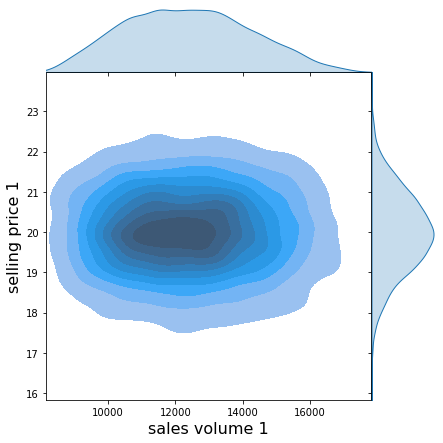

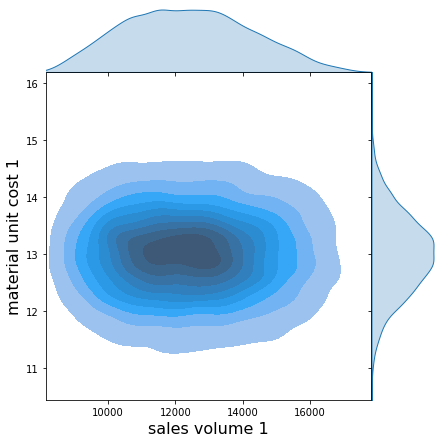

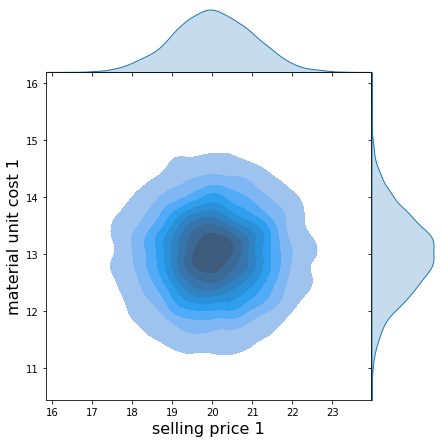

In [44]:
# call plot function: correlation structures BEFORE applying the Gaussian copula
plotcorr(rand_P, rand_N1, "sales volume 1", "selling price 1")
plotcorr(rand_P, rand_N2, "sales volume 1", "material unit cost 1")
plotcorr(rand_N1, rand_N2, "selling price 1", "material unit cost 1")

In [45]:
# step 4: draw N random variates for each of the three marginal disibutions
# and use as inputs the correlated uniform scores we have generated in step 2

rand_P = d_P.ppf(rand_U[:, 0])                            # sales volume
rand_N1 = d_N1.ppf(rand_U[:, 1])                          # selling price
rand_N2 = d_N2.ppf(rand_U[:, 2])                          # raw material unit cost

In [46]:
# correlation structure AFTER applying the copula
c_after = np.corrcoef([rand_P, rand_N1, rand_N2])
c_after

array([[ 1.   , -0.294,  0.211],
       [-0.294,  1.   ,  0.696],
       [ 0.211,  0.696,  1.   ]])

In [47]:
# discrepancy of copula-imposed correlations vs targeted correlations
c_after - c_target

array([[ 0.   ,  0.006,  0.011],
       [ 0.006,  0.   , -0.004],
       [ 0.011, -0.004,  0.   ]])

In [48]:
# call plot function: correlation structures after applying the Gaussina copula
plotcorr(rand_P, rand_N1, "sales volume 2", "selling price 2")
plotcorr(rand_P, rand_N2, "sales volume 2", "material unit cost 2")
plotcorr(rand_N1, rand_N2, "selling price 2", "material unit cost 2")


In [ ]:
# set up the simulation model:

# input variables: assign the arrays of N random variables to shorter variable names
v = rand_P                           # sales volume, PERT distributed
p = rand_N1                          # selling price, normally distributed
m = rand_N2                          # material unit cost, normally distributed


# output variables
GP = v * (p - m - o)              # simulation output: Gross Profit
R = v * p                         # simulation output: Revenues
GM = GP / R                       # simulation output: Gross Margin
C = R - GP                        # simulation output: Total Cost

In [ ]:
# helper function to plot histogram of an array with N random variates
def plothist(data, name):
    hist = np.histogram(data, bins=100)
    histdist = rv_histogram(hist)

    X = np.linspace(data.min(), data.max(), 100)
    plt.title(name)
    plt.hist(data, density=True, bins=100)
    plt.plot(X, histdist.pdf(X), label="pdf")
    plt.show()


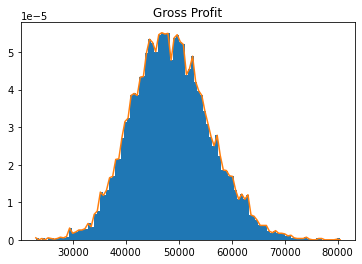

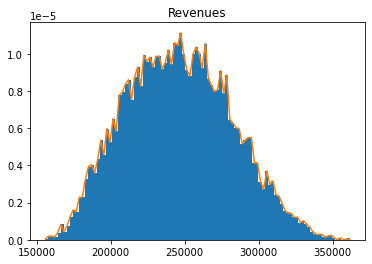

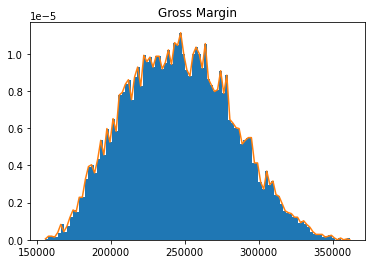

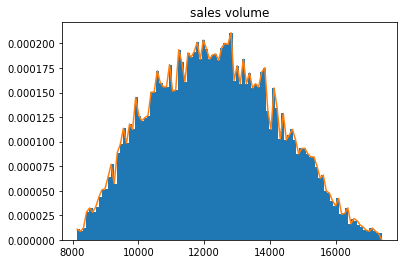

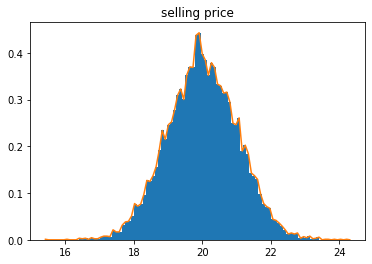

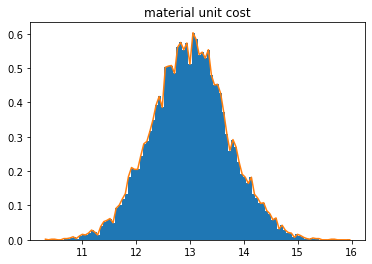

In [ ]:
# call the histogram plotter

plothist(GP, "Gross Profit")
plothist(R, "Revenues")
plothist(R, "Gross Margin")

plothist(v, "sales volume")
plothist(p, "selling price")
plothist(m, "material unit cost")